In [4]:
import math
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
# from scipy import stats
import scipy.stats as stats
from sklearn import linear_model
# from scipy.stats import linregress
%matplotlib inline

In [8]:
path = "../State_of_Iowa_Salary_Book.csv"

In [9]:
def money_to_float(x):
    try:
        if type(x) == float:
            return x
        return float(x.strip('$'))
    except ValueError:
        return float('nan')

def base_salary_to_float(x):
    try:
        if type(x) == float and math.isnan(x):
            return (None, float('nan'))
        elif type(x) == float:
            return (None, x)
        x = x.strip(" ")
        if x == "":
            return (None, float('nan'))
        elif x == "TERMINATED":
            return ("TERMINATED", float('nan'))
        elif x == "Terminated":
            return ("Terminated", float('nan'))
        elif x == "-0-":
            return ("-0-", float('nan'))
        elif x == "ON LEAVE":
            return ("ON LEAVE", float('nan'))
        elif x == "nan":
            return (None, float('nan'))
        elif x == float("nan"):
            return (None, float('nan'))
        else:
            s = x.replace('/', " ").split(' ')
            if len(s) < 2:
                return (None, float(s[0].strip('$').replace(',', "")))
            return (s[1], float(s[0].strip('$').replace(',', "")))
    except:
        # this is to show rows that failed the parsing
        print("<-"+x+"->", type(x))

In [10]:
# read csv
data = pd.read_csv(path, parse_dates=[0,8], converters={'Total Salary Paid': money_to_float, 'Base Salary': base_salary_to_float, 'Travel & Subsistence': money_to_float})
# split Base Salary tuple into two columns
base_salary_parsed = data["Base Salary"].apply(pd.Series).rename(columns={0:'Base Salary Payment Method', 1:'Base Salary Payment Amount'})
data.insert(8, 'Base Salary Payment Method', base_salary_parsed['Base Salary Payment Method'])
data.insert(9, 'Base Salary Payment Amount', base_salary_parsed['Base Salary Payment Amount'])
# delete Base Salary tuple column
data.pop("Base Salary")

('<-HR->', <type 'str'>)
('<-YR->', <type 'str'>)
('<-20.12HR->', <type 'str'>)
('<-262.99DA->', <type 'str'>)


0               (HR, 31.62)
1         (TERMINATED, nan)
2              (BW, 2212.8)
3              (BW, 1226.4)
4         (TERMINATED, nan)
5         (TERMINATED, nan)
6         (TERMINATED, nan)
7         (TERMINATED, nan)
8              (BW, 2194.4)
9         (TERMINATED, nan)
10        (TERMINATED, nan)
11        (TERMINATED, nan)
12             (BW, 3375.2)
13        (TERMINATED, nan)
14        (TERMINATED, nan)
15             (BW, 3349.6)
16           (YR, 144200.0)
17             (BW, 1237.6)
18             (BW, 2908.8)
19             (BW, 3193.6)
20        (TERMINATED, nan)
21             (BW, 1598.4)
22        (TERMINATED, nan)
23        (TERMINATED, nan)
24        (TERMINATED, nan)
25        (TERMINATED, nan)
26             (BW, 1180.8)
27             (BW, 3087.2)
28             (BW, 1437.6)
29             (BW, 4792.0)
                ...        
665295          (HR, 23.91)
665296        (HR, 25629.0)
665297          (HR, 22.88)
665298    (TERMINATED, nan)
665299          (HR,

In [11]:
# shows the unique payment types
print(data["Base Salary Payment Method"].unique())

# function to estimate hourly wages and hours worked, 
def hourly_estimates(x):
    # dictionary containing conversions of method to number of hours
    method_to_hour_estimate = {'HR': 1, 'BW': 80, 'YR': 2000, 'DA': 8, 'DAILY': 8, 
                               'AN': 2000, 'HRLY': 1, 'BM': 333.33, 'PW': 40}
    # get data from row
    method, amount_per_method, total = x["Base Salary Payment Method"], x["Base Salary Payment Amount"], x["Total Salary Paid"]
    # calc hourly wage and hours worked
    try:
        hourly_wage_estimate = amount_per_method / method_to_hour_estimate.get(method, np.nan) # if the dict does not have a conversion the default is NaN
        hours_worked_estimate = total/hourly_wage_estimate
    except ZeroDivisionError:
        hourly_wage_estimate = np.nan
        hours_worked_estimate = np.nan
    # return tuple
    return hourly_wage_estimate, hours_worked_estimate
# hours_parsed is a dataframe containing all of the hourly estimates
hour_parsed = data[["Base Salary Payment Method", "Base Salary Payment Amount", "Total Salary Paid"]] \
                    .apply(hourly_estimates, axis=1).apply(pd.Series).rename(columns={0:'Hourly Wage Estimate', 1:'Hours Worked Estimate'})  # axis one means that you apply the function on the row instead of the column
# if you were to do x.values it would give you the values of the complete row
data.insert(11, 'Hourly Wage Estimate', hour_parsed['Hourly Wage Estimate'])
data.insert(12, 'Hours Worked Estimate', hour_parsed['Hours Worked Estimate'])

['HR' 'TERMINATED' 'BW' 'YR' 'DA' nan '893.00' 'DAILY' 'AN' 'ON LEAVE'
 '-0-' 'HRLY' 'BM' 'PW' '' 'Terminated']


## Main Dataframe created

## Average Salary vs Inflation

Null Hypothesis: Does average salary 

In [12]:
# Salary calculations
salary_mean = pd.DataFrame(data.groupby(["Fiscal Year"])["Total Salary Paid"].mean())
salary_increase = salary_mean.diff()/salary_mean
salary_increase_change = salary_increase.diff()

salary_mean_norm = (salary_mean-salary_mean.min())/(salary_mean.max()-salary_mean.min())
salary_increase_norm = (salary_increase-salary_increase.min())/(salary_increase.max()-salary_increase.min())
salary_increase_change_norm = (salary_increase_change-salary_increase_change.min())/(salary_increase_change.max()-salary_increase_change.min())

In [13]:
# Inflation calculations
inflation_rate_tuples = [("2007",2.3), ("2008",2.3), ("2009",1.7), ("2010",1.0), ("2011",1.7),
           ("2012",2.1), ("2013",1.8), ("2014",1.7), ("2015",1.8), ("2016",2.2), ("2017",1.8)]
inflation_rate = pd.DataFrame(inflation_rate_tuples)
inflation_rate.insert(0, 2, pd.to_datetime(pd.DataFrame(inflation_rate_tuples)[0], format='%Y'))
inflation_rate.pop(0)
inflation_rate = inflation_rate.rename({2:"Fiscal Year", 1: "Inflation Rate"}, axis=1)
inflation_rate = inflation_rate.set_index("Fiscal Year")
inflation_rate = inflation_rate/100

inflation = (inflation_rate+1).cumprod()
# inflation_rate
inflation_rate_change = inflation_rate.diff()

inflation_norm = (inflation-inflation.min())/(inflation.max()-inflation.min())
inflation_rate_norm = (inflation_rate-inflation_rate.min())/(inflation_rate.max()-inflation_rate.min())
inflation_rate_change_norm = (inflation_rate_change-inflation_rate_change.min())/(inflation_rate_change.max()-inflation_rate_change.min())

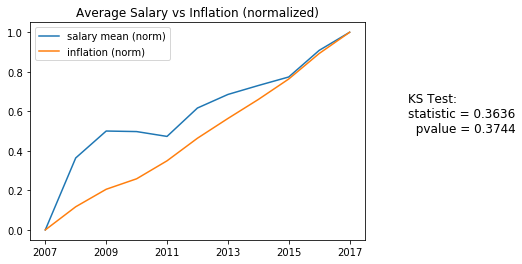

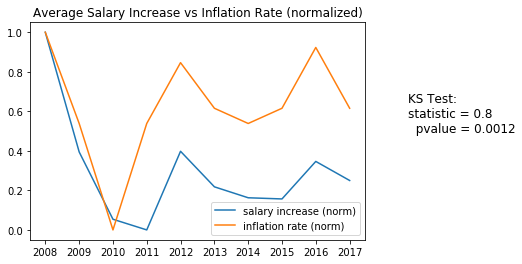

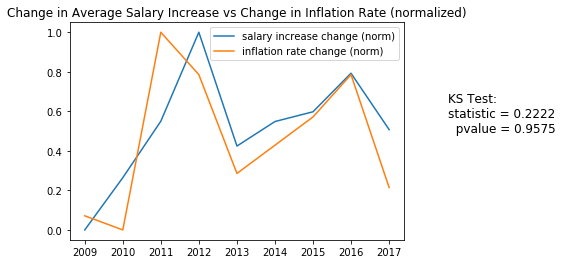

In [14]:
r = stats.ks_2samp(salary_mean_norm["Total Salary Paid"], inflation_norm["Inflation Rate"])
# print(r)
plt.figure().text(1, 0.5,
        "KS Test:\nstatistic = "+str(round(r.statistic, 4))+"\n  pvalue = "+str(round(r.pvalue, 4)),
                 size=12)
plt.title("Average Salary vs Inflation (normalized)")
plt.plot(salary_mean_norm)
plt.plot(inflation_norm)
plt.legend(["salary mean (norm)", "inflation (norm)"])
plt.show()

r = stats.ks_2samp(salary_increase_norm[1:]["Total Salary Paid"], inflation_rate_norm[1:]["Inflation Rate"])
# print(r)
plt.figure().text(1, 0.5,
        "KS Test:\nstatistic = "+str(round(r.statistic, 4))+"\n  pvalue = "+str(round(r.pvalue, 4)),
                 size=12)
plt.title("Average Salary Increase vs Inflation Rate (normalized)")
plt.plot(salary_increase_norm[1:])
plt.plot(inflation_rate_norm[1:])
plt.legend(["salary increase (norm)", "inflation rate (norm)"])
plt.show()

r = stats.ks_2samp(salary_increase_change_norm[2:]["Total Salary Paid"], inflation_rate_change_norm[2:]["Inflation Rate"])
# print(r)
plt.figure().text(1, 0.5,
        "KS Test:\nstatistic = "+str(round(r.statistic, 4))+"\n  pvalue = "+str(round(r.pvalue, 4)),
                 size=12)
plt.title("Change in Average Salary Increase vs Change in Inflation Rate (normalized)", )
# plt.annotate("hello", xy=(0,0))
plt.plot(salary_increase_change_norm[2:])
plt.plot(inflation_rate_change_norm[2:])
plt.legend(["salary increase change (norm)", "inflation rate change (norm)"])
# plt.text(.05,0.0005, "testing", ha='center')

plt.show()

These plots show that total inflation moves with total salary over time. Also that the change in inflation rate moves with the change of salary increases.

# SLR

SLR: 1.1222, se: 0.0974, T-value: 11.5219


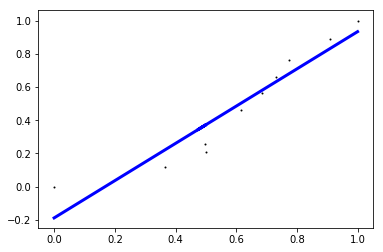

SLR: 0.6820, se: 0.1902, T-value: 3.5864


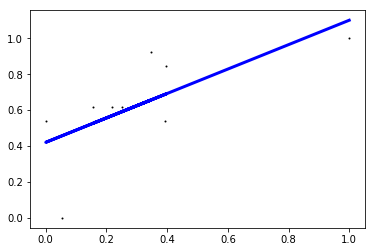

SLR: 0.9253, se: 0.2128, T-value: 4.3484


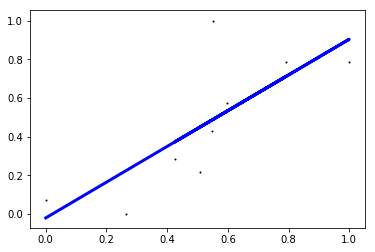

In [34]:
for train_x, train_y in zip([salary_mean_norm, salary_increase_norm[1:], salary_increase_change_norm[2:]], [inflation_norm, inflation_rate_norm[1:], inflation_rate_change_norm[2:]]):
    LR0 = linear_model.LinearRegression()
    LR0.fit(train_x, train_y)
    pred = LR0.predict(train_x)
    coef = LR0.coef_
    
    MAPE = 100 * sum(abs((p - y) / y) for y, p in zip(np.array(train_y), pred) if y != 0) / len([y for y in train_y if y != 0])
    se = math.sqrt(sum((p-y)**2 for y, p in zip(np.array(train_y), pred)) / len(pred))
    t_val = abs(coef / se)
    
    print("SLR: {0:.4f}, se: {1:.4f}, T-value: {2:.4f}".format(coef[0][0], se, t_val[0][0]))
    plt.scatter(train_x, train_y, color='black', s=1)
    plt.plot(train_x, pred, color='blue', linewidth=3)
    plt.show()

## Looking at effects from 2008 stock market crash and other events

Null Hypothesis: The effects of the recession will effect salaries from year to year

In [220]:
inflation

,Inflation Rate
Fiscal Year,
2007-01-01,1.023000
2008-01-01,1.046529
2009-01-01,1.064320
2010-01-01,1.074963
2011-01-01,1.093238
2012-01-01,1.116196
2013-01-01,1.136287
2014-01-01,1.155604
2015-01-01,1.176405


In [286]:
def inflation_adjust(x):
    i_rate = float(inflation.loc[x["Fiscal Year"]])
    r = []
    for i, v in enumerate(x):
        if i in [8, 10, 11, 13]:
            r.append(v/i_rate)
        else:
            r.append(v)
    return r
data_inflation_adjusted = data.apply(inflation_adjust, axis=1)

In [242]:
float(inflation.loc['2007-01-01'].values)

1.023

<function matplotlib.pyplot.show>

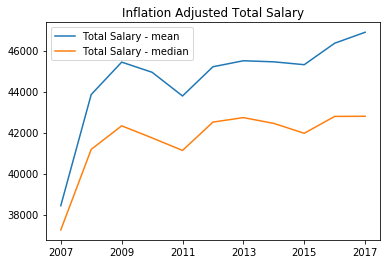

In [392]:
plt.plot(data_inflation_adjusted.groupby("Fiscal Year")["Total Salary Paid"].mean())
plt.plot(data_inflation_adjusted.groupby("Fiscal Year")["Total Salary Paid"].median())
plt.legend(["Total Salary - mean", "Total Salary - median"])
plt.title("Inflation Adjusted Total Salary")
plt.show

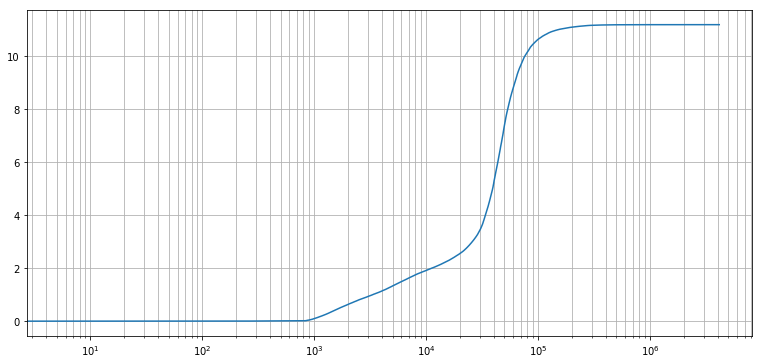

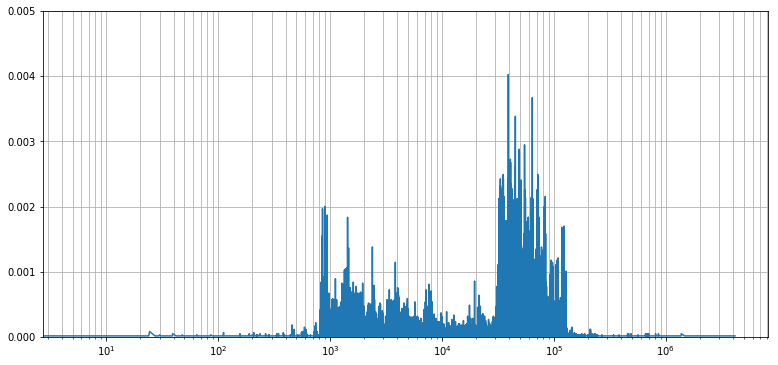

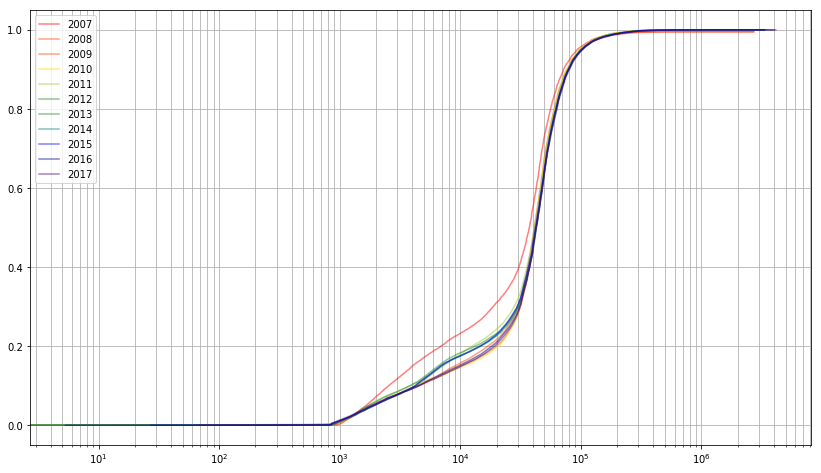

In [311]:
# cdfs for inflation adjusted total salaries

# cdf with x-axis log scale
plt.figure(figsize=(13, 6))
plt.grid(True, which="both")
p = plt.plot(data_inflation_adjusted["Total Salary Paid"].value_counts().sort_index().apply((lambda x: x/l)).cumsum().iloc[2:]) # the array slicing gets ride of negative salary
plt.semilogx(True)
plt.show()


# pdf with x-axis log scale
plt.figure(figsize=(13, 6))
plt.grid(True, which="both")
p = plt.plot(data_inflation_adjusted["Total Salary Paid"].value_counts().sort_index().apply((lambda x: x/l)).iloc[2:]) # the array slicing gets ride of negative salary
plt.semilogx(True)
plt.ylim([0, 0.005])
plt.show()


plt.figure(figsize=(14, 8))
plt.grid(True, which="both")
# l = len(data["Total Salary Paid"])  # this plots the full CDF on top of the yearly CDFs
# plt.plot(data["Total Salary Paid"].value_counts().sort_index().apply((lambda x: x/l)).cumsum(), label="all", color="black", alpha=0.3)
colors = ['#FF0000', '#FF4500', '#FF4500', '#FFD700', '#9ACD32', '#228B22', '#228B22', '#008080', '#0000FF', '#00008B', '#4B0082']
for k, i in enumerate(data_inflation_adjusted.groupby(["Fiscal Year"])):
    title = i[0]
    i = i[1]
    l = len(i["Total Salary Paid"])
    plt.plot(i["Total Salary Paid"].value_counts().sort_index().apply((lambda x: x/l)).cumsum(),
            label=str(title)[:4],
            color=colors[k],
            alpha=0.5)
plt.semilogx(True, basex=10)
plt.legend(loc='best')
plt.show()

In [345]:
def WaldsTest(df1, df2):
    w = (df1.mean() - df2.mean())/np.sqrt(df1.var()/len(df1) + df2.var()/len(df2))
    p_value = 2 * (1 - stats.norm.cdf(abs(w)))
    return w, p_value

In [357]:
# def TTest(df):
#     t = df.mean() / np.sqrt(df.var()/len(df))
#     return t

In [340]:
total_salary_by_year = [data_inflation_adjusted.loc[data_inflation_adjusted["Fiscal Year"] == (str(i)+"-01-01")]["Total Salary Paid"] for i in range(2007,2018)]
# pd.concat()  # use this to concat different years together

In [387]:
for i in range(len(total_salary_by_year)-1):
    w, p = WaldsTest(total_salary_by_year[i], total_salary_by_year[i+1])
    if p < 0.05:
        s = "diff"
    else:
        s = "same"
    print(i+2007, i+2007+1, s, w, p)

# the dataset is quite large so errors tend to be small, 
# the results below show that there are still years that are very similar to one another

2007 2008 diff -26.582776570996028 0.0
2008 2009 diff -7.317337227866538 2.5290880500961066e-13
2009 2010 diff 2.2548702240844816 0.02414147579807535
2010 2011 diff 5.076237909786543 3.849812066913927e-07
2011 2012 diff -6.03722016476449 1.5679173515081857e-09
2012 2013 same -1.2208178107949528 0.222155008655623
2013 2014 same 0.21874647348697976 0.8268475449460473
2014 2015 same 0.559736357332458 0.575659279414487
2015 2016 diff -4.119903829845212 3.79030568347094e-05
2016 2017 diff -2.069895952495265 0.03846208906109938


In [384]:
# pre recession, effects of recession, market rising, election
# 2007, 2008-2012, 2013-2016, 2017

the_gaps = [(2007,2007+1),(2008, 2012+1),(2013, 2016+1),(2017, 2017+1)]

for i in range(len(the_gaps)-1):
    a1 = the_gaps[i][0]-2007
    a2 = the_gaps[i][1]-2007
    b1 = the_gaps[i+1][0]-2007
    b2 = the_gaps[i+1][1]-2007
    d1 = pd.concat(total_salary_by_year[a1:a2])
    d2 = pd.concat(total_salary_by_year[b1:b2])
    w, p = WaldsTest(d1, d2)
    print(the_gaps[i], the_gaps[i+1])
    print("wald stat", w, "p-value", p)

# each group of years are different from each other

(2007, 2008) (2008, 2013)
wald stat -40.36348505364705 p-value 0.0
(2008, 2013) (2013, 2017)
wald stat -8.906900393239514 p-value 0.0
(2013, 2017) (2017, 2018)
wald stat -6.048230778718599 p-value 1.464450782862059e-09


## Looking at salaries and Effective Federal Funds Rate

In [35]:
effr_path = "effr.csv"
# effr_data = pd.read_csv(effr_path, parse_dates=True, infer_datetime_format=True, header=0, converters={'"EFFR (PERCENT)"': money_to_float})
# dp = lambda x: pd.datetime.strptime(str(x), '%m/%d/%Y')
effr_data = pd.read_csv(effr_path)
def effr_parser(x):
    try:
        t = pd.datetime.strptime(str(x[0]).split('[')[0], '%m/%d/%y')
    except ValueError:
        t = pd.datetime.strptime(str(x[0]).split('[')[0], '%Y-%m-%d')
    t = t.year
    n = np.float(x[1])
    return [t, n]
effr_data = effr_data.apply(effr_parser, axis=1)
effr_data = effr_data.set_index("DATE")
effr_data = effr_data.sort_index()
effr_data = effr_data.groupby("DATE").mean()

# effr_data_by_year = effr_data.apply(lambda x: (x[0].year, x[1]), axis=1).groupby("DATE").mean()

In [465]:
effr_data

,EFFR (PERCENT)
DATE,
2007.0,5.026454
2008.0,1.939048
2009.0,0.159722
2010.0,0.177024
2011.0,0.101833
2012.0,0.142112
2013.0,0.107809
2014.0,0.089004
2015.0,0.134286


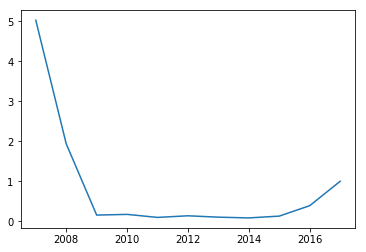

In [466]:
plt.plot(effr_data)

SLR: -3.8171, se: 1.0176, T-value: 3.7509


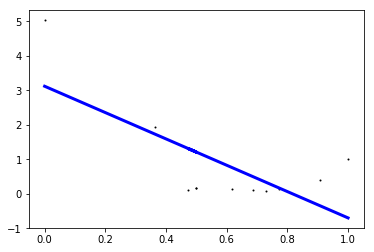

In [51]:
for train_x, train_y in zip([salary_mean_norm[0:], salary_mean_norm[1:]], [effr_data.iloc[0:], effr_data.iloc[1:]]):
    LR0 = linear_model.LinearRegression()
    LR0.fit(train_x, train_y)
    pred = LR0.predict(train_x)
    coef = LR0.coef_

    MAPE = 100 * sum(abs((p - y) / y) for y, p in zip(np.array(train_y), pred) if y != 0) / len([y for y in train_y if y != 0])
    se = math.sqrt(sum((p-y)**2 for y, p in zip(np.array(train_y), pred)) / len(pred))
    t_val = abs(coef / se)

    print("SLR: {0:.4f}, se: {1:.4f}, T-value: {2:.4f}".format(coef[0][0], se, t_val[0][0]))
    plt.scatter(train_x, train_y, color='black', s=1)
    plt.plot(train_x, pred, color='blue', linewidth=3)
    plt.show()

# scrap from trying to get SLR to work

In [165]:
linregress(np.array(salary_mean["Total Salary Paid"]))

IndexError: tuple index out of range

In [168]:
from scipy import linspace

In [173]:
linspace(0,10,11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [174]:
salary_mean.values

array([[39314.82906565],
       [45896.4623022 ],
       [48360.71741126],
       [48311.35551131],
       [47868.01153203],
       [50465.34623521],
       [51707.09528695],
       [52524.66760504],
       [53306.32709834],
       [55738.68204296],
       [57397.95954074]])

In [175]:
linregress(linspace(0,10,11), salary_mean.values)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [188]:
np.column_stack(salary_mean["Total Salary Paid"]).shape

(1, 11)

In [195]:
linregress(np.column_stack(linspace(0,10,11)), np.column_stack(salary_mean_norm["Total Salary Paid"]))

/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=0.07887163551697175, intercept=0.20101507310449546, rvalue=0.9477292670550389, pvalue=nan, stderr=nan)

In [178]:
np.column_stack(linspace(0,10,11))

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]])

In [179]:
salary_mean.shape

(11, 1)

In [197]:
np.column_stack(salary_mean["Total Salary Paid"])

array([[39314.82906565, 45896.4623022 , 48360.71741126, 48311.35551131,
        47868.01153203, 50465.34623521, 51707.09528695, 52524.66760504,
        53306.32709834, 55738.68204296, 57397.95954074]])

In [198]:
linregress(np.column_stack(linspace(0,10,11)), np.column_stack(salary_mean_norm["Total Salary Paid"]))

/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=0.07887163551697175, intercept=0.20101507310449546, rvalue=0.9477292670550389, pvalue=nan, stderr=nan)

In [199]:
np.column_stack(linspace(0,10,11))

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]])

In [200]:
np.column_stack(salary_mean_norm["Total Salary Paid"])

array([[0.        , 0.36396537, 0.50023907, 0.49750935, 0.47299235,
        0.61662538, 0.6852943 , 0.73050618, 0.77373207, 0.90824169,
        1.        ]])

In [208]:
linregress(np.column_stack(0, 10, 11), np.column_stack(inflation_norm["Inflation Rate"].values))

TypeError: column_stack() takes 1 positional argument but 3 were given

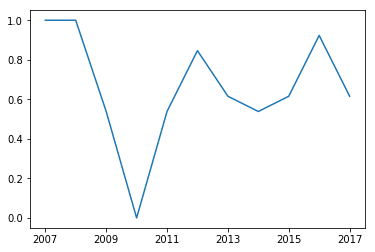

In [214]:
plt.plot(inflation_rate_norm["Inflation Rate"])

In [216]:
linregress(np.column_stack(linspace(0,10,11)), np.column_stack(salary_mean_norm["Total Salary Paid"]))

/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=0.07887163551697175, intercept=0.20101507310449546, rvalue=0.9477292670550389, pvalue=nan, stderr=nan)

In [217]:
salary_mean_norm["Total Salary Paid"]

Fiscal Year
2007-01-01    0.000000
2008-01-01    0.363965
2009-01-01    0.500239
2010-01-01    0.497509
2011-01-01    0.472992
2012-01-01    0.616625
2013-01-01    0.685294
2014-01-01    0.730506
2015-01-01    0.773732
2016-01-01    0.908242
2017-01-01    1.000000
Name: Total Salary Paid, dtype: float64

In [218]:
linspace(0,10,11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [219]:
inflation_rate_norm["Inflation Rate"]

Fiscal Year
2007-01-01    1.000000
2008-01-01    1.000000
2009-01-01    0.538462
2010-01-01    0.000000
2011-01-01    0.538462
2012-01-01    0.846154
2013-01-01    0.615385
2014-01-01    0.538462
2015-01-01    0.615385
2016-01-01    0.923077
2017-01-01    0.615385
Name: Inflation Rate, dtype: float64